# Experiment XAI

Primer de tot descarregam les dades. Aquestes dades els hem obtingut del dataset [MURA](https://stanfordmlgroup.github.io/competitions/mura/), una vegada que ho hem obtingut les hem organitzades seguint la forma per defecte del ``ImageDataGenerator`` de la llibreria Keras. 

Descarregam les dades i **descomprimim** les dades.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [55]:
TRAIN = False
IMAGE_SHAPE = (224, 224, 3)
TRAIN_PATH = 'MURA/train'
VAL_PATH = 'MURA/validation'
WEIGHT_FILES = 'mura.hdf5'

In [3]:
if False:
    !wget https://www.dropbox.com/s/r0wrxxvpvffwx1w/mura.zip?dl=1 -O mura.zip
    !unzip mura.zip

## Importam les llibraries

In [4]:
import itertools

import cv2
from tqdm.auto import tqdm
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from skimage import transform
from skimage import segmentation
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from xai import algorithms as xai_algorithm
from skimage.segmentation import mark_boundaries

import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as k_applications
import tensorflow_datasets as tfds
import tensorflow.keras.models as keras_model
import tensorflow.keras.layers as keras_layer
from tensorflow import keras
import glob
import os

import lime
from lime import lime_image
from xai import algorithms as xai_algorithms

## Generadors de dades

In [38]:
# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagent = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
        'MURA/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode='rgb',
        batch_size=5,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

validation_ds = val_datagent.flow_from_directory(
        'MURA/valid',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode='rgb',
        batch_size=1,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels


train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

Found 35523 images belonging to 7 classes.
Found 3008 images belonging to 7 classes.


In [6]:
size = (512, 512)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [7]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(1).prefetch(buffer_size=10)

# Model

Empram un model de l'estat de l'art, una **ResNet101** (veure [*Deep Residual Learning for Image Recognition* ](https://arxiv.org/abs/1512.03385)). De l'arquitectura original eliminam les capes denses i afegim les nostres pròpies. **No feim *transfer learning***.

In [8]:
model = k_applications.ResNet101(include_top=False, input_tensor=keras_layer.Input(IMAGE_SHAPE), weights="imagenet")

for l in model.layers[:-5]:
    l.trainable = False
    
# x = keras_layer.GlobalAveragePooling2D()(model.layers[-1].output)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = keras.layers.Dense(1)(x)
x = keras_layer.Flatten()(model.layers[-1].output)
x = keras_layer.Dense(256, activation='relu')(x)
x = keras_layer.Dropout(0.5)(x)
x = keras_layer.Dense(256, activation='relu')(x)
x = keras_layer.Dropout(0.5)(x)

x = keras_layer.Dense(1, activation='sigmoid')(x)

model = keras_model.Model(inputs=model.input, outputs=x)
model.compile(optimizer=Adam(1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['binary_accuracy'])



In [56]:
model = k_applications.VGG16(include_top=False, input_tensor=keras_layer.Input(IMAGE_SHAPE), weights="imagenet")

for l in model.layers[:-5]:
    l.trainable = False

x = keras_layer.Flatten()(model.layers[-1].output)
x = keras_layer.Dense(256, activation='relu')(x)
x = keras_layer.Dropout(0.5)(x)
x = keras_layer.Dense(256, activation='relu')(x)
x = keras_layer.Dropout(0.5)(x)

x = keras_layer.Dense(7, activation='softmax')(x)

model = keras_model.Model(inputs=model.input, outputs=x)
model.compile(optimizer=Adam(1e-5), loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['categorical_accuracy'])

In [57]:
model.summary()

Model: "model_426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

## Entrenam el model

Una vegada que tenim definit el model i les dades preparades entrenam el model. L'entrenam amb 50 èpoques.

In [58]:
if TRAIN:
    history = model.fit(train_ds, validation_data=validation_ds, validation_steps=10, epochs=5, 
                        callbacks=[tf.keras.callbacks.ModelCheckpoint(WEIGHT_FILES, verbose=0,
                                                                      save_weights_only=False,
                                                                      save_best_only=True)])
else:
    model.load_weights(WEIGHT_FILES)

Una vegada entrenat mostram els gràfics de les pèrdua i l'accuracy per època per poder obervar el procés d'entrenament. Per altra part,  mostrarem, la matriu de confusió i un conjunt de mètriques de classificació per poder coneixer la qualitat de les prediccions.

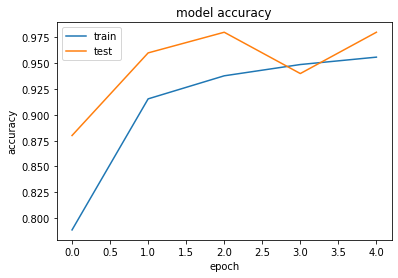

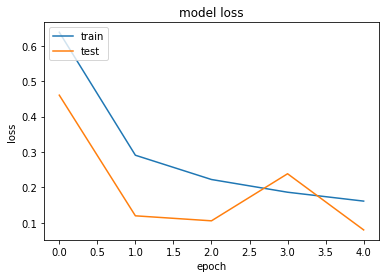

In [13]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = []
gt = []

# for i in tqdm(range(20)):
#     predictions.append(model.predict(val_generator[i][0]))
#     gt.append(val_generator[i][1])
for tt in val_generator:
    predictions = predictions + list(map(lambda x: x[0], model.predict(tt[0]).tolist()))
#     gt = gt + tt[1]
    gt.append(tt[1])
    
# predictions = np.array(list(itertools.chain.from_iterable(predictions)))
# gt = np.array(list(itertools.chain.from_iterable(gt)))
# predictions = np.argmax(predictions, axis = 1)
# gt = np.argmax(gt, axis = 1)

In [27]:
val_generator.class_indices.keys()

dict_keys(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST'])

Obtenim les mètriques tipiques de classificació per classe. A més mostram la matriu de confusió.

In [ ]:
print(metrics.classification_report(y_true=gt, y_pred=pred, target_names=["C", "D"]))

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=gt, y_pred=pred)  # shape=(12, 12)
df_cm = pd.DataFrame(confusion_matrix, index = ['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST'],
                  columns = ['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues");

Podem observar que les pitjors classes són l'avantbraç (*forearm*). Així i tot podem veure que hi ha relativament poca confussió entre les classes.

# XAI

Una vegada que tenim un model entrenat podem aplicar-hi tècniques de XAI.

Primerament llegim una imatge que emprarem per trobar la seva explicació. S'ha de tenir en compte que la xarxa està entrenada amb imatges de 244px per 244px, per tant deformam la imatge. Si ens interessas evitar aquesta deformació el que podriem fer és afegir píxels negres per evitar la deformació. 

Un altre element a tenir en compte és que li passam imatges de tres canals, diria que podriem passar imatges monocanals sense perdre informació.


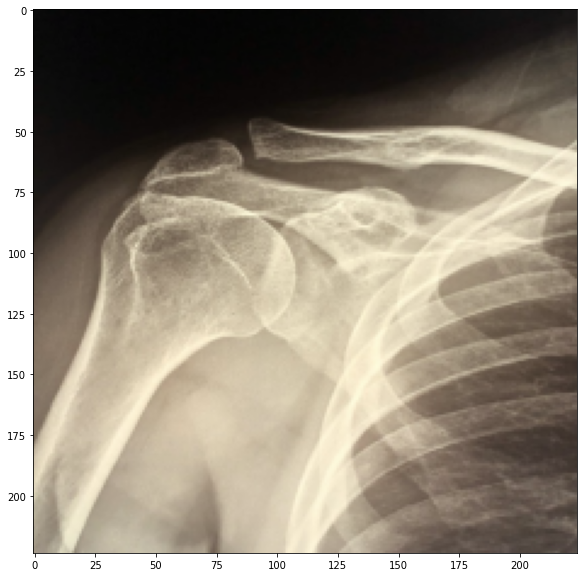

In [62]:
image = cv2.imread('arm.jpg')
image = skimage.transform.resize(image, (224, 224, 3))
plt.imshow(image)

In [60]:
image = tt[0][0,:,:, :]

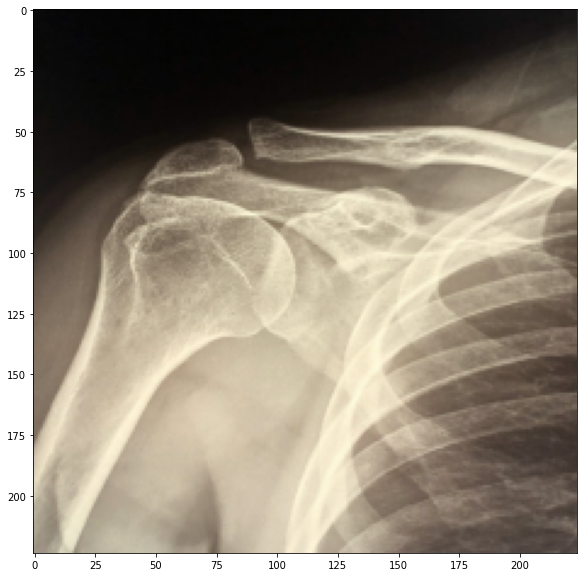

In [67]:
# image = cv2.imread("./dataset_gros/validation/o/o0195.jpg")
# image = skimage.transform.resize(image, IMAGE_SHAPE)
out_image = (np.copy(image) * 255).astype(np.uint8)
# out_image = (out_image * 255).astype(np.uint8)


plt.imshow(out_image)
plt.show()

Una vegada que tenim la imatges miram quina és la predicció que obté el model.

In [63]:
pred = model.predict(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])))
names = np.array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST'])

for name, v in zip(names[np.argsort(pred)[0][::-1]], sorted(pred[0][::-1], reverse=True)):
    print(f"Classe {name}, probabilitat {v}")

Classe SHOULDER, probabilitat 0.9888201355934143
Classe HUMERUS, probabilitat 0.0034493552520871162
Classe WRIST, probabilitat 0.0022494301665574312
Classe ELBOW, probabilitat 0.0018538943259045482
Classe HAND, probabilitat 0.0014582328731194139
Classe FINGER, probabilitat 0.0012681150110438466
Classe FOREARM, probabilitat 0.0009009544737637043


Definim el map de color que aplicarem a les diferents explicacions. **Sempre aplicarem el mateix**. L'objectiu es tenir una visualització uniforme

In [30]:
def apply_cmap(heatmap, size = (224, 224, 3)):
    maxim = heatmap.max()
    if maxim > 1:
        viridis = cm.get_cmap("viridis", lut=maxim)
    else:
        viridis = cm.get_cmap("viridis")


    heatmap = viridis(heatmap)[:,:,:3] * 255
    heatmap = transform.resize(heatmap, size)
    heatmap = heatmap.astype(np.uint8)
    
    return heatmap


## LIME

Primerament aplicarem la tècnica [LIME](https://arxiv.org/abs/1606.05386). Aquesta tècnica permet obtenir un conjunt diferent de visualitzacions però internament és una única explicació.

LIME, en aquest context, és un algorismes que consisteix en tres part, una primera que agrupa els píxels en superpíxels; una segona que amaga una part d'aquests superpíxels per fer tests d'oclussió i una tercera que entrena un classificador líneal per prediure el canvis entre classe produïts per aquesta oclussió.


In [129]:
explainer = lime_image.LimeImageExplainer()

Podem veure que fa una predicció correcte, predint la classe colze, i que la segona amb molta distància és l'avantbraç.
 
Una vegada que sabem la predicció que obté el model empram LIME per obtenir l'explicació. Farem diferents visualitzacions de la mateixa explicació. 

In [92]:
explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Explicació classificació amb major probabilitat: colze

#### Superpíxels amb un pes major que 10% positiu

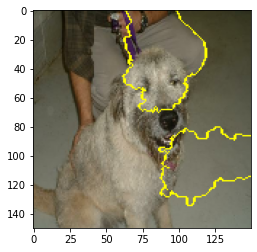

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

#### Superpíxels amb un pes major que 10% positiu (eliminam la resta de la imatge).

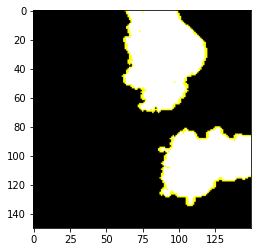

In [61]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, 
                                            hide_rest=True, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

#### Superpíxels amb un pes major que 10% tant positiu com negatiu. 

Verd -> Positiu.

Vermell -> Negatiu.

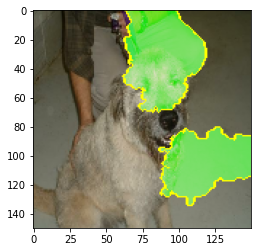

In [63]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask));

#### Cinc superpíxels amb més pes. 

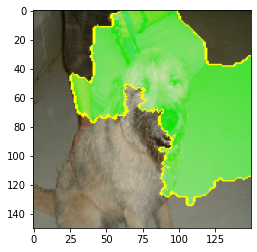

In [64]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

#### Tots els superpíxels, tant positius com negatius

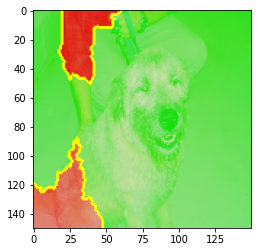

In [65]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

#### Mapa de color amb tots els superpíxels

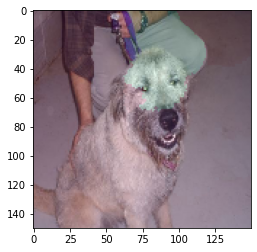

In [66]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap = np.abs(heatmap)
heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
out = cv2.addWeighted(out_image, 1, heatmap, 0.35, 0.0)
plt.imshow(out)
# plt.colorbar();

## GradCAM

Classe D, probabilitat 3.4338046728948912e-12


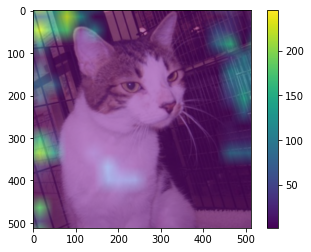

In [18]:
heatmap = xai_algorithms.grad_cam(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, 'conv5_block3_out')
heatmap = np.uint8(255 * heatmap)

heatmap = apply_cmap(heatmap, IMAGE_SHAPE)
# out_image = image * 255 
# out_image = out_image.reshape((224, 224, 3))
# out_image = out_image.astype(np.uint8)
dst = cv2.addWeighted(out_image, 0.5, heatmap, 0.85, 0.0) 


plt.imshow(dst)
plt.colorbar();

pred = model.predict(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])))
names = np.array(["D", "C"])

for name, v in zip(names[np.argsort(pred)[0][::-1]], sorted(pred[0][::-1], reverse=True)):
    print(f"Classe {name}, probabilitat {v}")

In [32]:
plt.rcParams["figure.figsize"] = (20, 10)

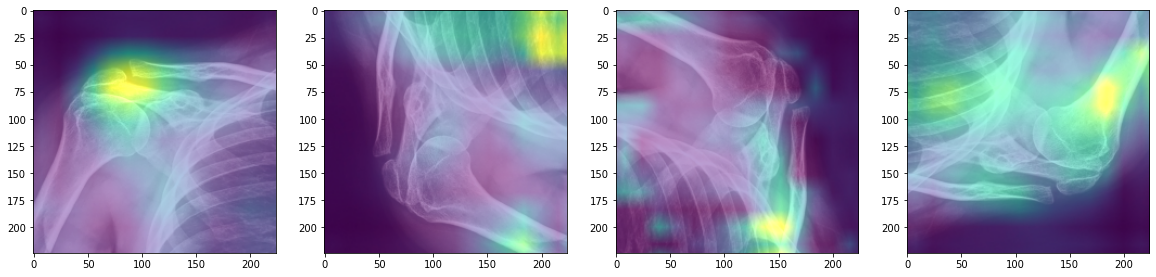

In [70]:
plt.subplot(1, 4, 1)
heatmap = xai_algorithms.grad_cam_plus(model, image.reshape(IMAGE_SHAPE), 'block5_conv3')
heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

dst = cv2.addWeighted(out_image, 0.5, heatmap, 0.85, 0.0) 
plt.imshow(dst)

for idx, rot in enumerate([cv2.cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.cv2.ROTATE_90_CLOCKWISE, cv2.cv2.ROTATE_180]):
    plt.subplot(1, 4, idx + 2)
    img_rot = cv2.rotate(image, rot)
    heatmap = xai_algorithms.grad_cam_plus(model, img_rot.reshape(IMAGE_SHAPE), 'block5_conv3')
    heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

    dst = cv2.addWeighted(cv2.rotate(out_image, rot), 0.5, heatmap, 0.85, 0.0) 
    plt.imshow(dst)

# plt.imshow(dst)

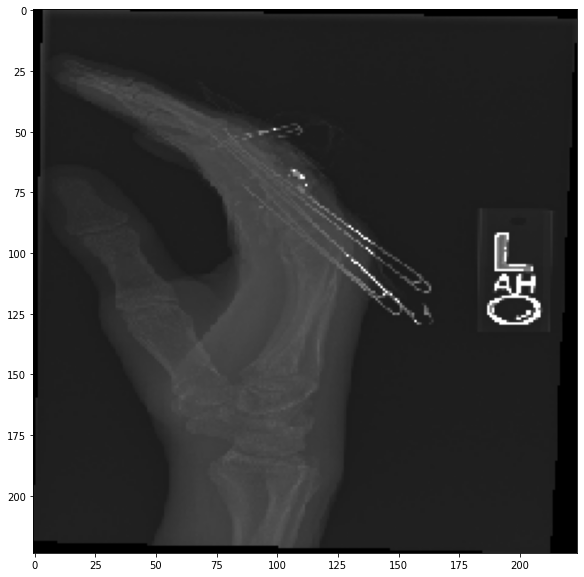

In [66]:
plt.imshow(out_image)

## Test d'oclussió
### Malla d'oclussions

In [43]:
grid = xai_algorithms.build_grid(1, 10, IMAGE_SHAPE)
grid = xai_algorithms.print_bboxes(grid, ((IMAGE_SHAPE[0], IMAGE_SHAPE[1])))
heatmap = xai_algorithms.occlusion_test(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, grid)

In [44]:
heatmap[:,:,0].shape

(512, 512)

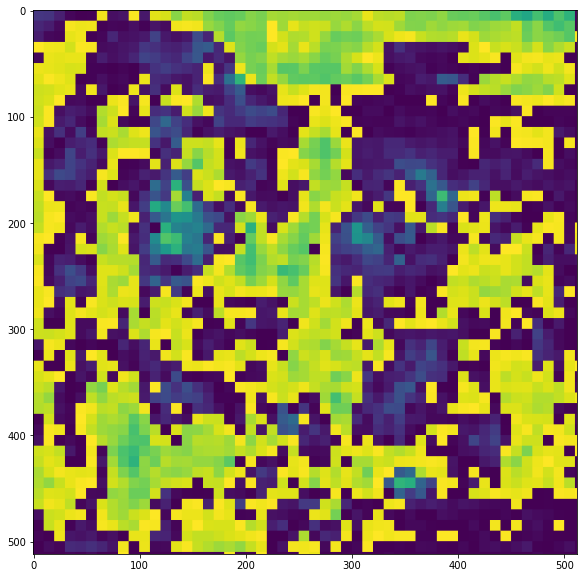

In [45]:
heatmap = apply_cmap(heatmap[:,:, 0], IMAGE_SHAPE)
plt.imshow(heatmap);

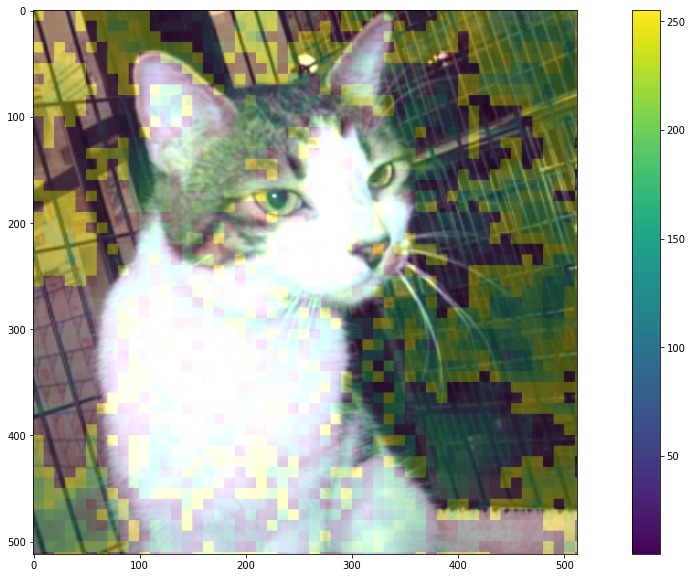

In [24]:
heatmap = heatmap.astype(np.uint8)

dst = cv2.addWeighted(out_image, 1, heatmap, 0.35, 0.0) 

plt.imshow(dst)
plt.colorbar();

### Superpíxels

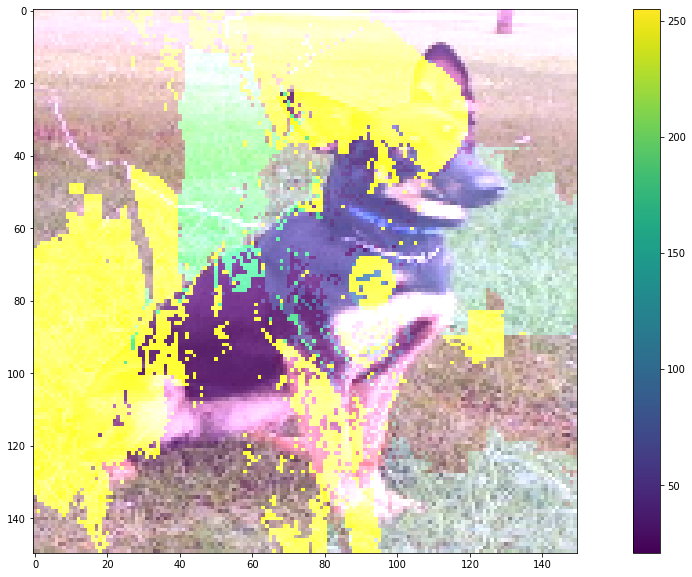

In [143]:
heatmap = xai_algorithms.occlusion_test(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, explanation.segments)

heatmap = heatmap.astype(np.uint8)
heatmap = apply_cmap(heatmap[:,:, 0], IMAGE_SHAPE)

dst = cv2.addWeighted(out_image[:,:,:], 1, heatmap[:, :, :], 1, 0.0) 

plt.imshow(dst)
plt.colorbar();

In [31]:
heatmap.dtype

dtype('uint8')

Les explicacions, semblen indicar que un dels elements més importants és l'articulació i el seu entorn i també sembla que quan més ens allunyam de la articulació (especialment part inferior de la imatge) més negativament afecta a la predicció.

## Exportam els resultats

Aplicam els resultats dels diferents mètodes a cada una de les imatges de validació

In [71]:
filenames = glob.glob("./dataset_gros/validation/**/*.jpg")
names = np.array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER', 'WRIST'])

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]

# for f in tqdm(filenames):
#     image = cv2.imread(f)

#     image = skimage.transform.resize(image, IMAGE_SHAPE)
for idx, test_info in enumerate(validation_ds):
    image = test_info[0][0, :, :, :]
    gt_class = names[np.argmax(test_info[1][0])]
    out_image = np.copy(image)
    out_image = (out_image * 255).astype(np.uint8)
    
#     break
#     gt_class = folder.split(os.path.sep)
    
    pred = model.predict(image.reshape(((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))))
    idx_str = str(idx).zfill(4)

    name = name.split(".")[0]
    out_path = os.path.join(".", "out", "mura_improved", gt_class, f"{names[int(np.argmax(pred))]}_{idx_str}")
    os.makedirs(out_path ,exist_ok=True)

    # Prediction 
    
    # LIME 
    #Select the same class explained on the figures above.
#     explainer = lime_image.LimeImageExplainer()
#     explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
#     ind =  explanation.top_labels[0]

#     #Map each explanation weight to the corresponding superpixel
#     dict_heatmap = dict(explanation.local_exp[ind])
#     heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
#     heatmap = np.abs(heatmap)
#     heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

#     #Plot. The visualization makes more sense if a symmetrical colorbar is used.
#     dst = cv2.addWeighted(out_image, 1, heatmap, 0.35, 0.0)
#     dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)

#     cv2.imwrite(os.path.join(out_path, "lime.png"), dst)
    
    # GradCAM
    heatmap = xai_algorithms.grad_cam(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, 'block5_conv3')
    heatmap = np.uint8(255 * heatmap)
    heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

    dst = cv2.addWeighted(out_image, 1, heatmap, 0.85, 0.0)
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(os.path.join(out_path, "grad_cam.png"), dst)
    
    # GradCAM++
    heatmap = xai_algorithms.grad_cam_plus(model, image.reshape(IMAGE_SHAPE), 'block5_conv3')
    heatmap = apply_cmap(heatmap, IMAGE_SHAPE)

    dst = cv2.addWeighted(out_image, 0.5, heatmap, 0.85, 0.0) 
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)

    cv2.imwrite(os.path.join(out_path, "grad_cam_plus.png"), dst)
    
#     print("Starting oclussion ...")
#     # Occlussion (malla)
#     grid = xai_algorithms.build_grid(1, 10, IMAGE_SHAPE)
#     grid = xai_algorithms.print_bboxes(grid, ((IMAGE_SHAPE[0], IMAGE_SHAPE[1])))
#     heatmap = xai_algorithms.occlusion_test(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, grid)
    
#     heatmap = apply_cmap(heatmap[:,:, 0], IMAGE_SHAPE)
# #     heatmap = heatmap.astype(np.uint8)
#     dst = cv2.addWeighted(out_image, 1, heatmap, 0.35, 0.0)
#     dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)

#     cv2.imwrite(os.path.join(out_path, "occlu_malla.png"), dst)
    
#     # Occlussion (superpíxels)
#     heatmap = xai_algorithms.occlusion_test(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, explanation.segments)
#     heatmap = heatmap.astype(np.uint8)
#     heatmap = apply_cmap(heatmap[:,:, 0], IMAGE_SHAPE)
    
#     dst = cv2.addWeighted(out_image, 1, heatmap, 0.35, 0.0)
#     dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)

#     cv2.imwrite(os.path.join(out_path, "occlu_super_pixels.png"), dst)
    

KeyboardInterrupt: 

tf.Tensor([0], shape=(1,), dtype=int64)


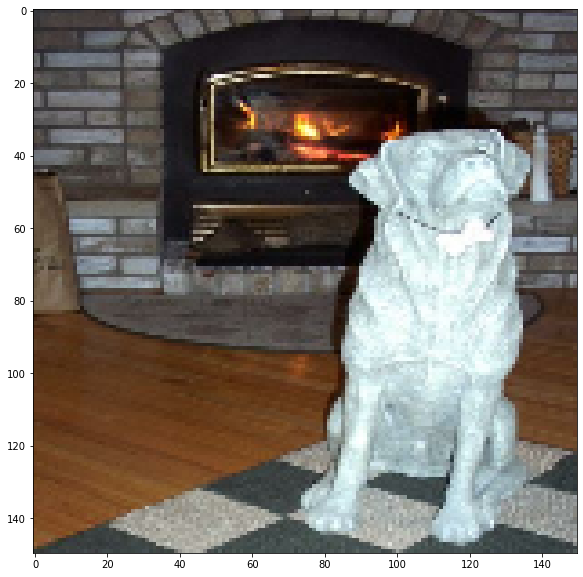

In [180]:
print(test_info[1][0].numpy())
plt.imshow(out_image)

In [175]:
gt_class

'C'

In [43]:
heatmap = xai_algorithms.grad_cam(image.reshape((1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])), model, 'conv5_block3_3_conv')
heatmap = np.uint8(255 * heatmap)
heatmap = apply_cmap(heatmap)

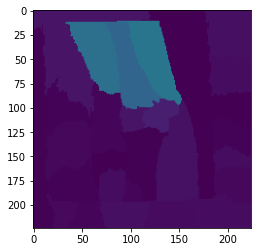

In [46]:
plt.imshow(heatmap)